# Creating Watermarked Images

In [46]:
# !pip install --upgrade kagglehub

import os
import kagglehub
import pandas as pd
from PIL import Image

In [60]:
def read_images_dataset(images_path):
    image_files = [f for f in os.listdir(images_path) if f.lower()
                   .endswith(('.jpg', '.jpeg', '.png'))]
    image_data = []

    for image_file in image_files:
        image_path = os.path.join(images_path, image_file)

        img = Image.open(image_path)

        image_data.append({
            "image_name": image_file,
            "image_path": image_path,
            "image_size": img.size
        })

    return pd.DataFrame(image_data)

## [The Oxford-IIIT Pet Dataset](https://www.kaggle.com/datasets/tanlikesmath/the-oxfordiiit-pet-dataset)

We need to resize the images if the Oxford-IIIT Pet dataset matches the ones required for the image classifier. We plan to use either Tiny-Vit 5M or MobileViT-XXS 1.3M for image classification. Both of these models use images of 224x224 pixels.

In [58]:
def load_oxford_pet_dataset():
    return kagglehub.dataset_download("tanlikesmath/the-oxfordiiit-pet-dataset")

In [61]:
def read_oxford_pet_dataset():
    path = load_oxford_pet_dataset()
    images_path = f'{path}/images'
    return read_images_dataset(images_path)


oxford_pet_dataset = read_oxford_pet_dataset()
oxford_pet_dataset.head(5)

,image_name,image_path,image_size
0,Abyssinian_1.jpg,/home/jovyan/.cache/kagglehub/datasets/tanlike...,"(600, 400)"
1,Abyssinian_10.jpg,/home/jovyan/.cache/kagglehub/datasets/tanlike...,"(375, 500)"
2,Abyssinian_100.jpg,/home/jovyan/.cache/kagglehub/datasets/tanlike...,"(394, 500)"
3,Abyssinian_101.jpg,/home/jovyan/.cache/kagglehub/datasets/tanlike...,"(450, 313)"
4,Abyssinian_102.jpg,/home/jovyan/.cache/kagglehub/datasets/tanlike...,"(500, 465)"


In [65]:
def resize_image(image_path, dim):
    image = Image.open(image_path)
    if image.mode != 'RGB':
        image = image.convert('RGB')
    new_size = (dim, dim)
    resized_image = image.resize(new_size)
    return resized_image

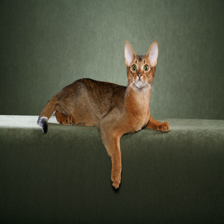

In [66]:
resize_image(oxford_pet_dataset['image_path'][0], 224)

In [67]:
def save_resize_oxford_pet_dataset(original_dataset):
    output_dir = "resized_images"

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for index, row in original_dataset.iterrows():
        input_image_path = row['image_path']
        resized_image = resize_image(input_image_path, 224)

        output_image_path = os.path.join(output_dir, row['image_name'])
        resized_image.save(output_image_path)

    return output_dir


resized_dataset_dir_path = save_resize_oxford_pet_dataset(oxford_pet_dataset)
resized_oxford_pet_dataset = read_images_dataset(resized_dataset_dir_path)
resized_oxford_pet_dataset.head(5)

,image_name,image_path,image_size
0,Abyssinian_1.jpg,resized_images/Abyssinian_1.jpg,"(224, 224)"
1,Abyssinian_10.jpg,resized_images/Abyssinian_10.jpg,"(224, 224)"
2,Abyssinian_100.jpg,resized_images/Abyssinian_100.jpg,"(224, 224)"
3,Abyssinian_101.jpg,resized_images/Abyssinian_101.jpg,"(224, 224)"
4,Abyssinian_102.jpg,resized_images/Abyssinian_102.jpg,"(224, 224)"


## [QMUL-OpenLogo Dataset](https://hangsu0730.github.io/qmul-openlogo/)
We need to edit the images in this dataset by converting them to black-and-white, applying a specified opacity, and rotating them by a given angle.

In [74]:
qmul_openlogo_dataset = read_images_dataset('qmul_openlogo_dataset')
qmul_openlogo_dataset.head(5)

,image_name,image_path,image_size
0,accenture.jpg,qmul_openlogo_dataset/accenture.jpg,"(391, 129)"
1,abus.jpg,qmul_openlogo_dataset/abus.jpg,"(985, 313)"
2,adidas.jpg,qmul_openlogo_dataset/adidas.jpg,"(282, 199)"
3,adidas_text.jpg,qmul_openlogo_dataset/adidas_text.jpg,"(310, 83)"
4,adidas1.jpg,qmul_openlogo_dataset/adidas1.jpg,"(244, 146)"


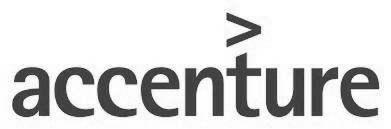

In [75]:
def convert_to_grayscale(image_path):
    image = Image.open(image_path)
    return image.convert('L')


convert_to_grayscale(qmul_openlogo_dataset['image_path'][0])

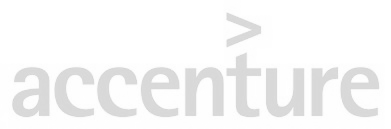

In [90]:
# Adjust the opacity value (0 to 1)
def change_opacity(image_path, opacity_value):
    opacity = int(opacity_value * 255)
    image = convert_to_grayscale(image_path)
    image = image.convert("RGBA")

    data = image.getdata()

    new_data = []
    for item in data:
        new_item = new_item = item[:3] + (opacity,)
        new_data.append(new_item)

    image.putdata(new_data)
    return image


change_opacity(qmul_openlogo_dataset['image_path'][0], 0.2)

## Creating the Final Dataset
We need to place the logo images at random locations within each image from the Oxford-IIIT Pet dataset.